Regarding Pre-Processing, it is necessary to select:
 - the best scaling strategy, necessary pre-processing step for the SVM classifier;
 - the best feature selection/feature extraction method. Try with:
    - PCA (feature extraction for dimensionality reduction);
    - Filter methods such as SelectKBest, SelectPercentile. The metric to use should be the f_classif (ANOVA correlation since attributes are numerical and targets are categorical).
- the best way to balance out the classes:
    - Oversampling;
    - Undersampling;
    - built-in methods used by SVC class.
- the best way to remove the outliers.
    
Regarding the classification, it is necessary to select:
 - the kernel function of the SVM (linear, polynomial, rbf, sigmoid) and the respective parameters (e.g. gamma for the rbf);
 - the regulatization parameter;
 - the multiclassification method (ovo or ova);
 
 Regarding the training procedure, it is necessary to select:
  - the best train\test split

In [2]:
# LIBRARIES

# util
import warnings
import numpy as np
from sklearn.exceptions import UndefinedMetricWarning

# dataset analysis
import pandas as pd
from pandas._libs import json

# pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
# --- feature extraction
from sklearn.decomposition import PCA
# --- feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif  # metrics for univariate feature selection
# --- class balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

# classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from imblearn.pipeline import Pipeline 
# - models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# scoring
from sklearn.metrics import make_scorer, accuracy_score, plot_confusion_matrix
import sklearn.metrics as met
from sklearn.metrics import classification_report, confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Functions

In [3]:
def class_balancing(df, method, labels):

    X = df[df.columns.tolist()[:-1]]
    y = df["Class"]

    if method == 'smote':
        sampler = SMOTE()
    elif method == 'adasyn':
        sampler = ADASYN()
    elif method == 'smote_tomek':
        sampler = SMOTETomek()
    elif method == 'smote_enn':
        sampler = SMOTEENN()
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    df_train_smt = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)

    fig, ax = plt.subplots(figsize=(10,5))
    graph = sns.countplot(ax=ax, x='Class', data=df_train_smt, order=labels)
    graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
    graph.bar_label(ax.containers[0]);
    ax.set_title(method.upper())

In [4]:
# for classification of categorical classes using numerical attributes we use f_classif (ANOVA correlation coefficient)

# this function will take in X, y variables with criteria, and return a dataframe with most important columns based on that criteria
def univariate_feature_selection(df, criteria, k):

    X = df[df.columns.tolist()[:-1]]
    y = df["Class"]

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X

In [5]:
def naive_classification(df):

    df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)
    df_traindata, df_trainlabel = df_train.iloc[:, 0:len(df_train.columns) - 1], df_train.iloc[:, -1]
    df_testdata, df_testlabel = df_test.iloc[:, 0:len(df_test.columns) - 1], df_test.iloc[:, -1]

    warnings.filterwarnings('ignore')
    # Baseline - comparing model accuracy using all features across classifiers
    classifiers = [
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        KNeighborsClassifier(),
        SVC(),
        GaussianNB(),
        LogisticRegression(),
        MLPClassifier()
    ]

    # Naive Train Accuracy
    algo = ['DTC', 'RFC', 'KNN', 'SVC', 'GNB', 'LR', 'MLP']
    # algo = []
    scores = []
    for clf in classifiers:
        # algo.append(clf.__class__.__name__)
        scores.append(cross_val_score(clf, df_traindata, df_trainlabel, cv=5).mean())
    warnings.filterwarnings('ignore')
    Naivescore_df_Train = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

    # Naive Test Accuracy
    algo = ['DTC', 'RFC', 'KNN', 'SVC', 'GNB', 'LR', 'MLP']
    # algo = []
    scores = []

    for clf in classifiers:
        clf = clf.fit(df_traindata, df_trainlabel)
        y_pred = clf.predict(df_testdata)
        # algo.append(clf.__class__.__name__)
        scores.append(accuracy_score(y_pred, df_testlabel))
    warnings.filterwarnings('ignore')
    Naivescore_df_Test = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

    # Bar plot between Train and Test Accuracy
    fig = plt.figure(figsize=(5, 5))  # Create matplotlib figure

    ax = fig.add_subplot(111)  # Create matplotlib axes
    ax2 = ax.twinx()  # Create another axes that shares the same x-axis as a
    width = .3

    Naivescore_df_Train.Score.plot(kind='bar', color='green', ax=ax, width=width, position=0)
    Naivescore_df_Test.Score.plot(kind='bar', color='red', ax=ax2, width=width, position=1)

    ax.grid(None, axis='y')
    ax2.grid(None)

    ax.set_ylabel('Train')
    ax2.set_ylabel('Test')

    ax.set_xlim(-1, 6)

In [6]:
def model_grid_search(X_train, X_test, y_train, y_test, scores, pipe, model_name, model_parameters_grid, n_cv = 5):
    
    # Creates an empty dictionary with best parameters for every scoring parameter considered
    best_parameters = {key: None for key in scores}

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,20), dpi=100, squeeze=False)
    fig.suptitle("Hyperparameters selection results: " + model_name.upper(), fontsize=28)

    print("\n================================================================================================================================================================\n")
    print("GRID SEARCH FOR " + model_name.upper() + ':')

    # Cross-validation **for every score!**
    for score, ax in zip(scores, ax.reshape(-1)):

        print("\n ---> Tuning " + model_name.upper() + " hyper-parameters for %s" % score.upper() + ": ")
        print()

        clf = GridSearchCV(
            estimator = pipe,
            param_grid = model_parameters_grid,
            scoring = score,
            n_jobs = -1,
            verbose = 4,
            return_train_score = True,
            cv = n_cv
            )

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            clf.fit(X_train, y_train)


        # PLOTTING CROSS VALIDATION RESULTS:

        print("\n ---> Grid scores on development set:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("     ---> %r: %0.3f (+/-%0.03f) for %r" % (score, mean, std * 2, params))

        # FINAL CLASSIFICATION ON TEST SET WITH BEST PARAMETERS (THAT MAXIMISE THE CURRENT SCORE)
        
        print("\n ---> CLASSIFICATION ON THE TEST SET - Detailed classification report:")
        print("     --- The model is trained on the full development set.")
        print("     --- The scores are computed on the full evaluation set.\n")
        
        # PLOT RESULTS

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            y_true, y_pred = y_test, clf.predict(X_test)
            print(classification_report(y_true, y_pred))
        print()

        print("\n ---> BEST PARAMETERS SET found on development set:\n")
        print(clf.best_params_)
        best_parameters[score] = clf.best_params_

        print("\n------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
        
        # PLOT CONFUSION MATRIX

        cm = confusion_matrix(y_test, y_pred, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2%', cmap='icefire', ax=ax)
        ax.set_title('Grid search results obtained trying to maximise for: ' + score.upper())

        # set x-axis label and ticks. 
        ax.set_xlabel("Predicted Class", fontsize=14)
        ax.xaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])

        # set y-axis label and ticks
        ax.set_ylabel("Actual Class", fontsize=14)
        ax.yaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])

        
    return best_parameters

In [7]:
def pipeline_final_traintest(pipe, X_train, X_test, y_train, y_test, best_parameters, selected_score):
    
    # Print the best parameters configurations that maximise specific metric/scores
    print("List of the parameters used according to a specific scoring parameter:")
    print(json.dumps(best_parameters, indent=4))
    print()

    # Final classification with optimized parameters:
    print("Classification:")
    print("Hyperparameter set found doing grid seach to maximise the %s scoring parameter" % selected_score.upper())

    # Instantiate a new classifier object with best parameters for a selected scoring parameter
    clf = pipe
    clf.set_params(**best_parameters[selected_score])
    
    # Model training:
    print("Model training:")
    with warnings.catch_warnings():
        warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
        # .. your divide-by-zero code ..
        clf.fit(X_train, y_train)

    # Model testing:
    print("\n\nMaking predictions:")
    with warnings.catch_warnings():
        warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
        # .. your divide-by-zero code ..
        y_predicted = clf.predict(X_test)

        # Performance evaluation
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_predicted))
        print()

        print(classification_report(y_test, y_predicted))
        print()

    
    # PLOT CONFUSION MATRIX

    fig = plt.figure(figsize=(12, 10))  # figure size is given as a (width, height) tuple
    ax1 = fig.add_subplot(111)
    cm = confusion_matrix(y_test, y_predicted, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='icefire', ax=ax1)
    ax1.set_title('Result obtained with parameters maxmimizing: ' + selected_score.upper())

    # set x-axis label and ticks. 
    ax1.set_xlabel("Predicted Class", fontsize=14)
    ax1.xaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])

    # set y-axis label and ticks
    ax1.set_ylabel("Actual Class", fontsize=14)
    ax1.yaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])
    
    return clf

# Dry Beans

## Dataset analysis

In [8]:
# Import dataset
df = pd.read_excel("DryBeanDataset/Dry_Bean_Dataset.xlsx")

### Dataset cleaning

In [9]:
df = df.drop_duplicates(ignore_index=True)
df.rename(columns = {'AspectRation':'AspectRatio'}, inplace = True)
df = df.astype({'Area': 'float64'})
df = df.astype({'ConvexArea': 'float64'})
df = df.astype({'Class': 'string'})

labels = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

features = df.columns.to_list();
features.remove('Class');
# features = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRatio', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 
#             'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2','ShapeFactor3', 'ShapeFactor4'];

df.info()
df.describe() 
# df[df['Class']=='BOMBAY'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13543 entries, 0 to 13542
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13543 non-null  float64
 1   Perimeter        13543 non-null  float64
 2   MajorAxisLength  13543 non-null  float64
 3   MinorAxisLength  13543 non-null  float64
 4   AspectRatio      13543 non-null  float64
 5   Eccentricity     13543 non-null  float64
 6   ConvexArea       13543 non-null  float64
 7   EquivDiameter    13543 non-null  float64
 8   Extent           13543 non-null  float64
 9   Solidity         13543 non-null  float64
 10  roundness        13543 non-null  float64
 11  Compactness      13543 non-null  float64
 12  ShapeFactor1     13543 non-null  float64
 13  ShapeFactor2     13543 non-null  float64
 14  ShapeFactor3     13543 non-null  float64
 15  ShapeFactor4     13543 non-null  float64
 16  Class            13543 non-null  string 
dtypes: float64(1

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000
mean,53048.460385,854.993406,319.895602,202.365321,1.581075,0.750315,53767.986709,253.034094,0.749829,0.987152,0.873671,0.800352,0.006561,0.001719,0.644341,0.995078
std,29392.438324,214.722684,85.809260,45.051632,0.245245,0.091858,29844.248525,59.307709,0.048939,0.004650,0.059393,0.061464,0.001130,0.000595,0.098653,0.004347
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36282.500000,703.230000,253.086806,175.886357,1.430662,0.715144,36673.000000,214.933277,0.718735,0.985678,0.833410,0.763228,0.005893,0.001158,0.582517,0.993720
50%,44580.000000,793.896000,296.404589,192.491117,1.549860,0.763997,45122.000000,238.245711,0.759903,0.988288,0.883490,0.801514,0.006643,0.001700,0.642424,0.996393
75%,61382.000000,977.146500,376.312489,217.245403,1.703916,0.809671,62360.000000,279.560351,0.786849,0.990019,0.917031,0.834470,0.007270,0.002173,0.696341,0.997891
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


### Feature distribution analysis

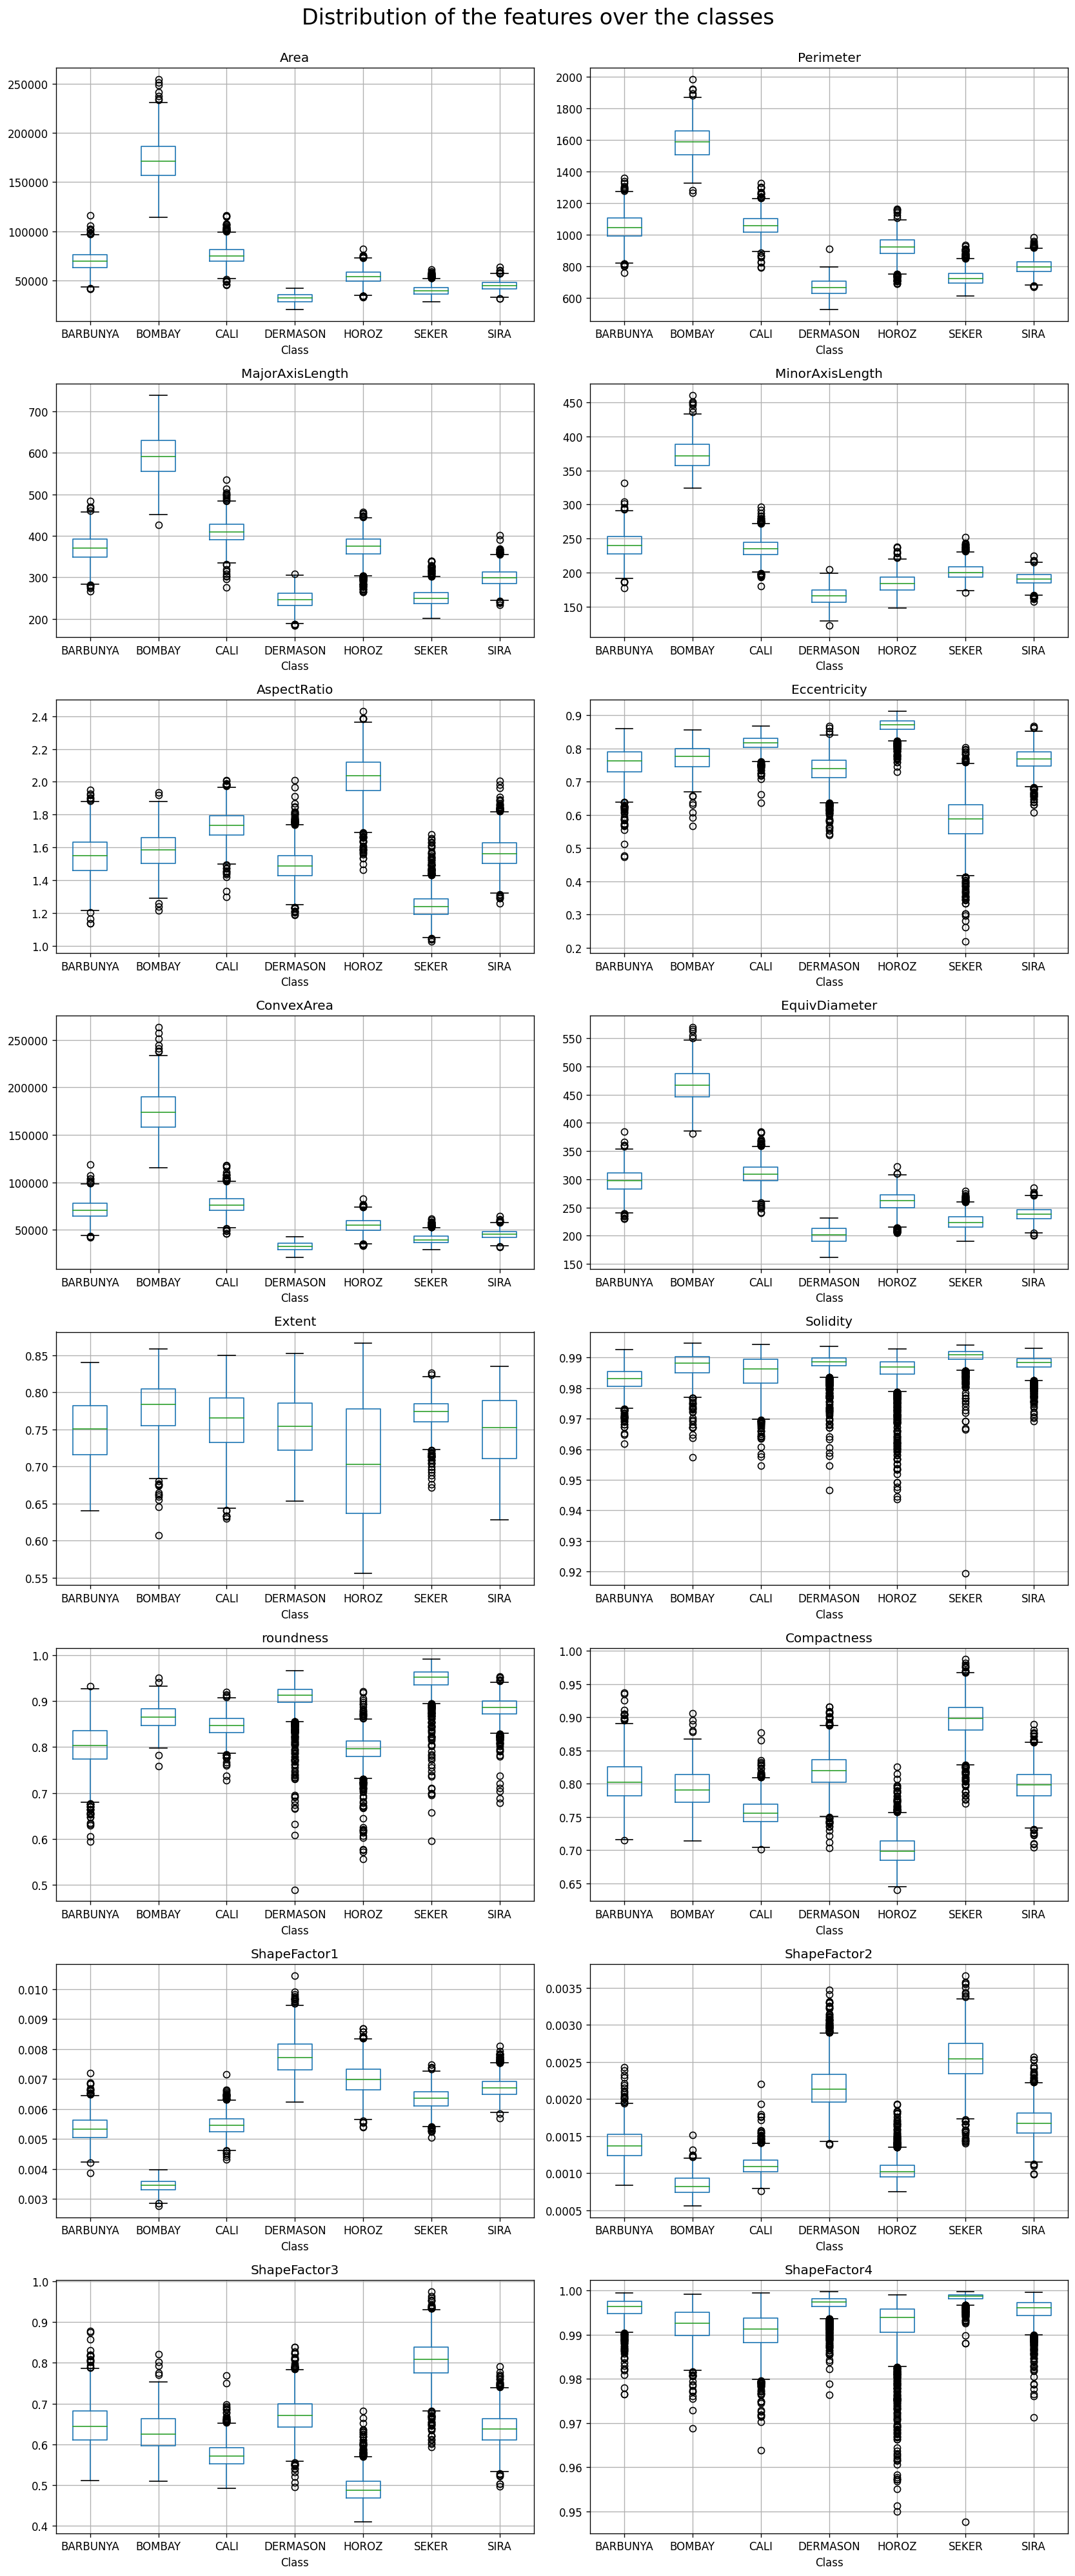

In [10]:
# BOXPLOTS
fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(14, 35), dpi=120)
for feature, ax in zip(features, ax.reshape(-1)):
    df.boxplot(feature, by='Class', ax=ax)
    # ax.axis('scaled')
plt.subplots_adjust()
fig.suptitle("Distribution of the features over the classes", fontsize=20);
# fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

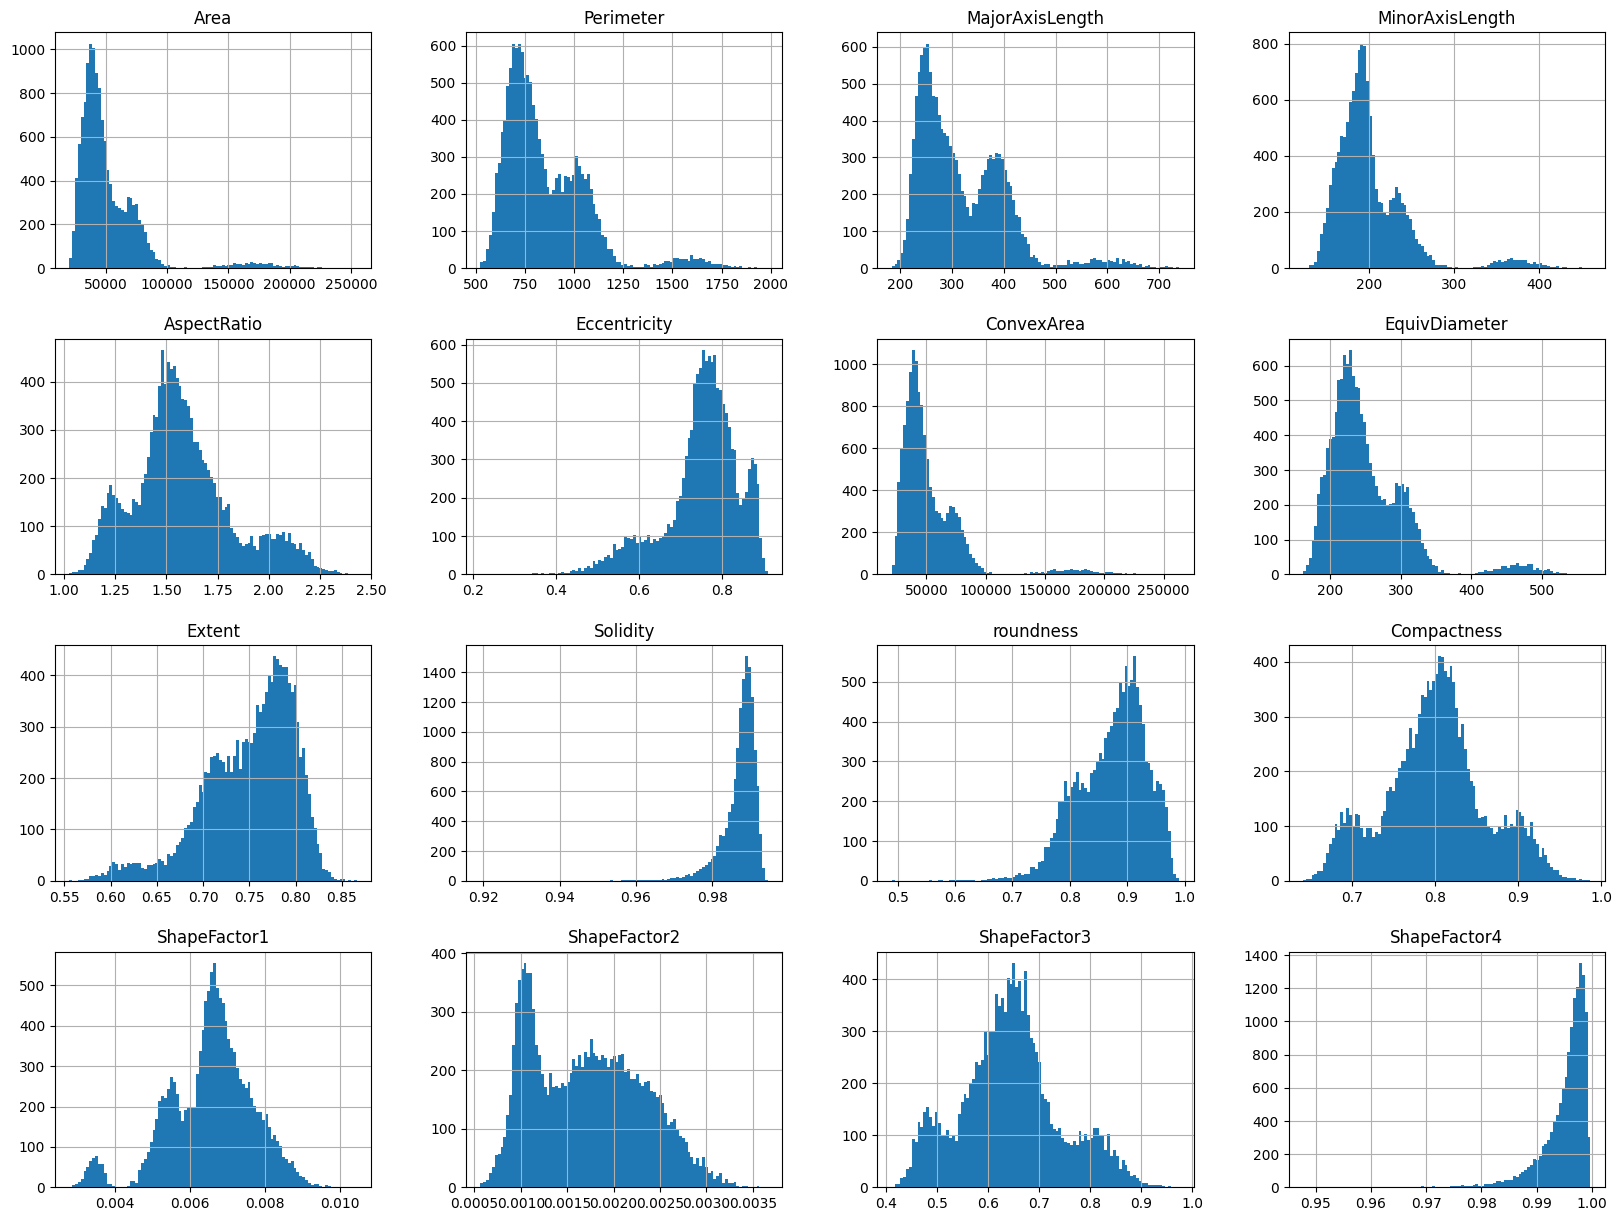

In [14]:
# HISTOGRAMS

df.hist(figsize=(20,15),bins=100); #Note: Through this plot we noticed the first correlations through shape
#df.groupby('Class').hist(figsize=(20,15),bins=100); #Note: It is not informative for our purposes

### Class distribution analysis

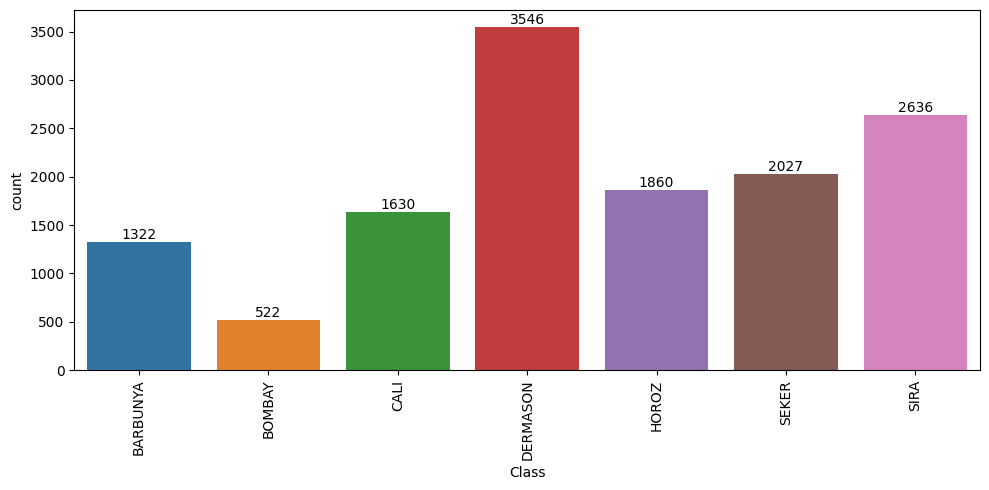

In [10]:
# CLASSES ANALYSIS

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);
fig.tight_layout()

#### Dropping the BOMBAY class

After observing the multivariate feature distribution we tried to dropp the BOMBAY class in order to see if it could improve the classification of the other classes.
If so, it could be possible to create a binary classifier for this class and successively classify the other classes.

In [11]:
#df = df[(df["Class"] != 'BOMBAY')];

## Pre-processing

### Class balancing: oversampling & hybridization

Here we explore the effect of different class balancing methods, we do not create copies of the original dataset applying these methods because these are implemented in the pipeline used in classification.

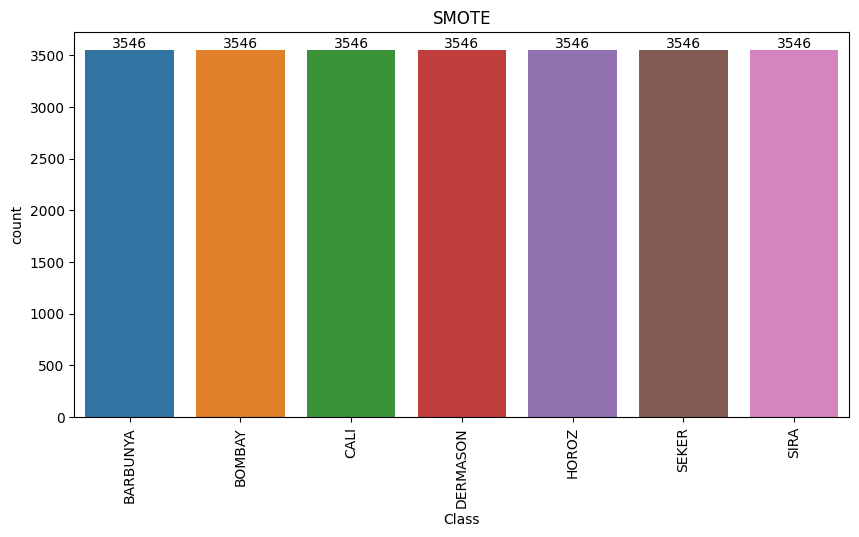

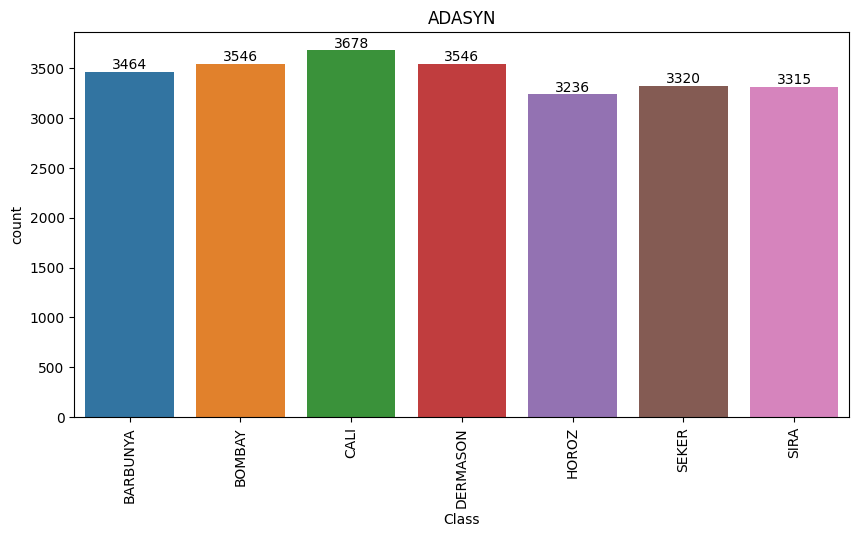

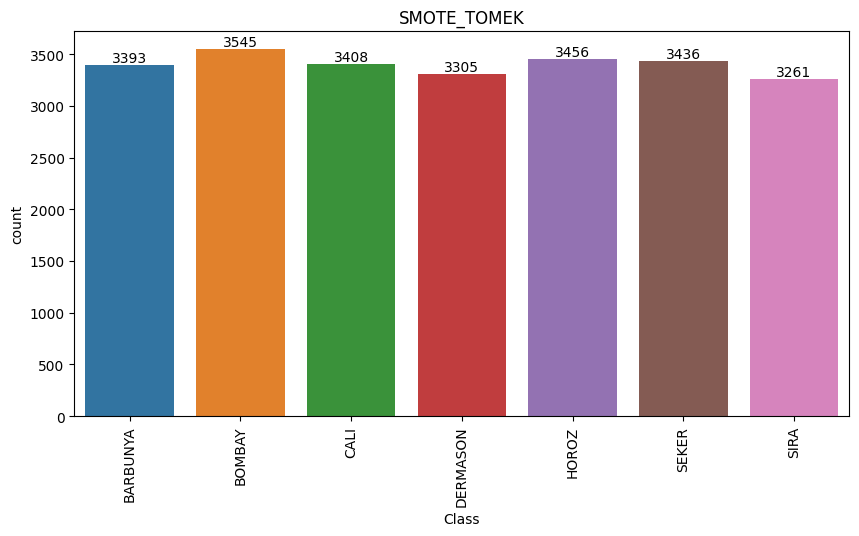

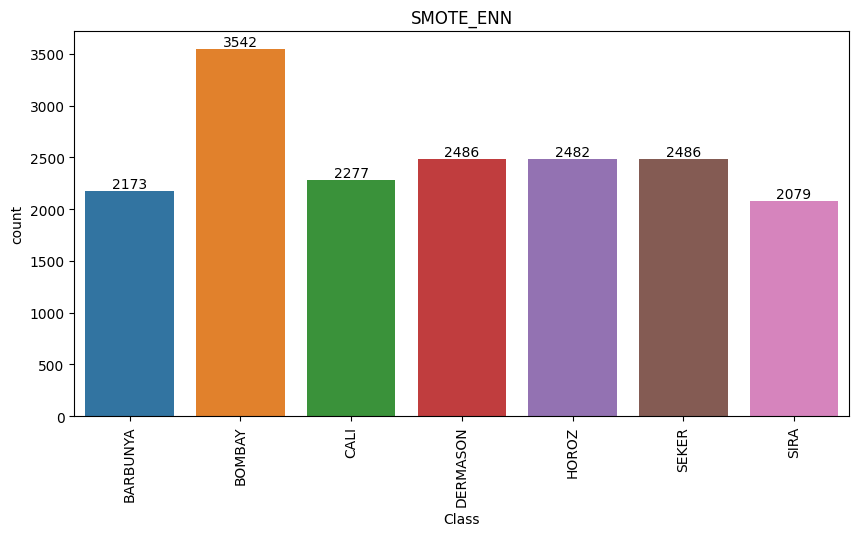

In [14]:
# OVERSAMPLING - SMOTE
class_balancing(df, 'smote', labels)

# OVERSAMPLING - ADASYN
class_balancing(df, 'adasyn', labels)

# HYBRIDIZATION - SMOTE TOMEK
class_balancing(df, 'smote_tomek', labels)

# HYBRIDIZATION - SMOTE ENN
class_balancing(df, 'smote_enn', labels)

### Feature Selection

Here we explore different methods of feature selections. 

Every method is applied to the original datasets and a new dataset is created and stored in a dictionary _datasets_.

In [45]:
datasets = {}
datasets['dataset_raw'] = df

#### A) Manual feature dropping due by qualitative analysis

In [47]:
# ARBITRARY DROPPING BY CORRELATION ANALYSIS
# Note: Area and ConvexArea are almost perfectly correlated: we already noticed that mathematically one is the square root of the other.
# Note: Compactness and Shape Factor 3 are almost perfectly correlated
# Proposition: Erase ConvexArea and Compactness

datasets['dataset_A'] = df.drop(['ConvexArea', 'EquivDiameter', 'Compactness'], axis=1)

#### B) Automatic feature dropping due to correlation analysis

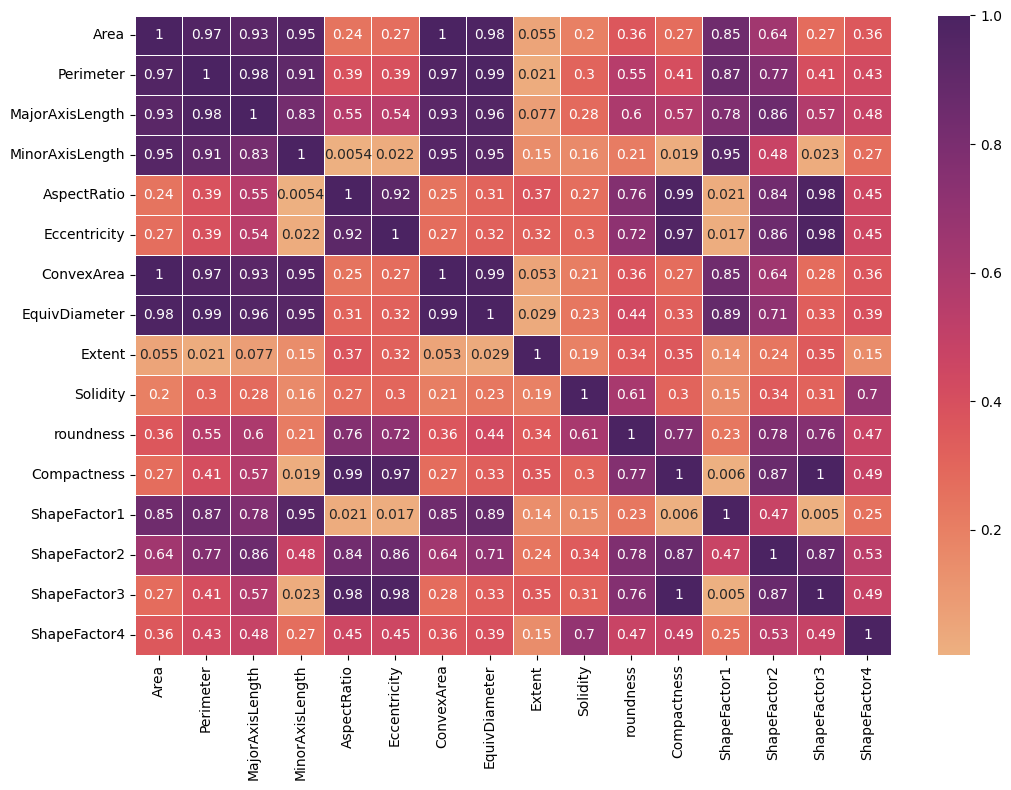

In [26]:
# CORRELATION
fig, ax = plt.subplots(figsize=(11,8)) 
CORR_MAP = df.corr(numeric_only = True).abs()
Steep = 10.0
Stretch = 2.002
if Stretch < 2.0 :
    Stretch = 2.0 
HIGH_CORR = (np.tan((np.pi/Stretch) * np.abs(CORR_MAP)) * (1 / Steep)) #LOW INFORMATION
LOW_CORR  = (np.tan((np.pi/Stretch) * (1 - np.abs(CORR_MAP))) * (1 / Steep)) #HIGH INFORMATION

sns.heatmap(CORR_MAP,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap(HIGH_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap(LOW_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"

fig.tight_layout()

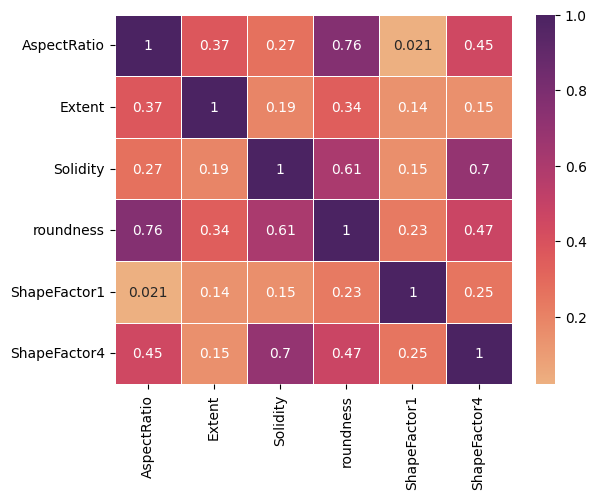

In [42]:
# PRUNING BY CORRELATION

corr = df.corr(numeric_only = True).abs()
drop = []
hold = []
p_threshold = 0.80

for i in range(0,corr.shape[0]):
    for j in range(i+1,corr.shape[1]):
        if corr.iloc[i,j]>=p_threshold:
            feature_i_corrsum = corr.iloc[i,:].sum()
            feature_j_corrsum = corr.iloc[j,:].sum()
            if feature_i_corrsum <= feature_j_corrsum:
                #hold.append(corr.index[i])
                #drop.append(corr.index[j])
                hold.append(i)
                drop.append(j)                
            else:
                #drop.append(corr.index[i])
                #hold.append(corr.index[j])
                drop.append(i)
                hold.append(j)

drop = list(set(drop))
drop = [list(corr.index)[i] for i in drop]
df_B = df.drop(drop, axis=1) 
corr = df_B.corr(numeric_only = True).abs()
sns.heatmap( corr,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r" """

datasets['dataset_B'] = df_B

#### C) Random Forest feature importance

In [41]:
# RANDOM FOREST FEATURE IMPORTANCE

Xf = df.iloc[:,:-1]
yf = df.iloc[:,-1:]
X_train_f, X_test_f, y_train_f, y_test_f  = train_test_split(Xf, yf, test_size=0.3)

rnd_clf = RandomForestClassifier(
    n_estimators = 64, 
    criterion="gini",                      # {"gini", "entropy", "log_loss"}  
    min_samples_split = 2,
    max_features = "sqrt",                 # {"sqrt", "log2", None}
    bootstrap = True,
    oob_score = False,
    min_samples_leaf = 1, 
    max_depth = None
    )
rnd_clf.fit(X_train_f, y_train_f.values.ravel())

y_pred_rf = rnd_clf.predict(X_test_f)
print(met.classification_report(y_pred_rf, y_test_f));

feat_score = rnd_clf.feature_importances_

features_importances = pd.DataFrame(list(zip(features, feat_score)), columns =['features', 'score']);
features_importances = features_importances.sort_values(by=['score'], ascending=False);
features_importances = features_importances.reset_index(drop = True);
No_of_best = 11
if No_of_best < 1 or No_of_best > len(features_importances):
    No_of_best = len(features_importances)
best_features = features_importances.iloc[:No_of_best,0].tolist()
best_features.append('Class')

df_C = df.filter(best_features , axis=1);
datasets['dataset_C'] = df_C 

              precision    recall  f1-score   support

    BARBUNYA       0.88      0.95      0.91       370
      BOMBAY       1.00      1.00      1.00       142
        CALI       0.93      0.92      0.93       480
    DERMASON       0.94      0.91      0.92      1092
       HOROZ       0.95      0.95      0.95       584
       SEKER       0.95      0.95      0.95       635
        SIRA       0.85      0.87      0.86       760

    accuracy                           0.92      4063
   macro avg       0.93      0.93      0.93      4063
weighted avg       0.92      0.92      0.92      4063



#### D) Univariate feature selection

In [6]:
# Extracting data
n_features = 5

# feature selection with f_classif (ANOVA correlation coefficient)
df_D = univariate_feature_selection(df, f_classif, k=n_features)

datasets['dataset_univariate'] = df_D

NameError: name 'df' is not defined

### Feature Extraction (alternative to Feature Selection)

#### Feature Scaling

In [15]:
X = df[df.columns.tolist()[:-1]]
y = df["Class"]

# Standardizing the features
# X = MinMaxScaler().fit_transform(X)
X = StandardScaler().fit_transform(X)

#### PCA

In [43]:
# Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. 
# The input data is centered but not scaled for each feature before applying the SVD.

pca = PCA(n_components = 2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

df_pca = pd.concat([principalDf, df[['Class']]], axis = 1)

datasets['dataset_pca'] = df_pca

## Classification

**ATTENTION**: Class Balancing cannot be done a priori since we perform K-Fold Cross Validation! It's included in a pipeline along with standard scaling.

### Pre-processed dataset selection for classification

In [48]:
chosen_df = datasets['dataset_A']

In [49]:
X = chosen_df[chosen_df.columns.tolist()[:-1]]
y = df["Class"]

### Train test split

In [ ]:
# Train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

### Naive classification

In [ ]:
# naive_classification(df)

### Hyperparameter selection (grid search and k-fold cross-validation)

In [ ]:
# Hyper-parameter optimization using k-fold cross validation: estimation of the classifier's parameters that maximise specific metrics/scores

models = {
    # "Random_Forest": RandomForestClassifier(
    #     min_samples_leaf=1, max_depth = None, bootstrap = True, 
    #     oob_score = False, min_samples_split = 2,
    #     ),
    # "Extra_Trees": ExtraTreesClassifier(
    #     min_samples_leaf=1, max_depth = None, bootstrap = False, 
    #     oob_score = False, min_samples_split = 2,
    #     ),
    # "KNN": KNeighborsClassifier(
    #     ),
    # "SVM": SVC(
    #     ),
    "MLP": MLPClassifier( 
        alpha=1e-5, 
        learning_rate='constant',
        max_iter=1000,
        tol=1e-4,
        verbose=False,
        momentum=0.9,
        early_stopping=False,
        )
}

# Set the parameters by cross-validation for different models
models_parameters_grids = {
    # "Random_Forest":
    #     {
    #         "Random_Forest__n_estimators": [256], 
    #         "Random_Forest__criterion": ["gini"],                    # {"gini", "entropy", "log_loss"}
    #         "Random_Forest__max_features": ["sqrt"],                 # {"sqrt", "log2", None}
    #     },
    # "Extra_Trees":   
    #     {
    #         "Extra_Trees__n_estimators":  [32], 
    #         "Extra_Trees__criterion": ["gini"],                    # {"gini", "entropy", "log_loss"}
    #         "Extra_Trees__max_features": ["sqrt"],                 # {"sqrt", "log2", None}
    #     },
    # "KNN": 
    #     {
    #         'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    #         'KNN__n_neighbors': [5, 10, 15],
    #     },
    # "SVM": 
    #     [
    #         {
    #             'SVM__kernel': ['rbf'],
    #             'SVM__gamma': [0.05, 0.1],
    #             'SVM__C': [100],
    #             'SVM__decision_function_shape': ['ovo'],  # by default this is set to ovr
    #         },   
    
    #         {   
    #             'SVM__kernel': ['linear'],
    #             'SVM__C': [1, 10, 100, 1000],
    #             'SVM__decision_function_shape': ['ovo'],
    #         }
    #     ],
    "MLP":
            {
                'MLP__activation': ['identity', 'logistic', 'tanh', 'relu'],    # {identity', 'logistic', 'tanh', 'relu'}
                'MLP__solver': ['adam',],     # {'lbfgs', 'sgd', 'adam'}
                'MLP__hidden_layer_sizes': [(12, 3), (16, 16), (256, 256), (16, 16, 16, 16)], 
                'MLP__learning_rate_init': [0.3, 0.1, 0.01],
            }
}

# Choose the metrics to optimize for
# scores = ['accuracy']
scores = ['accuracy']

models_best_parameters  = {
    # "Random_Forest": {},
    # "Extra_Trees": {},
    # "KNN": {},
    # "SVM": {},
    "MLP": {}
}

for model_name in models:
    # Creates a pipeline with the selected model (this is only done in order to apply the class balancing during correctly during k-fold cross validation)
    # No grid search is performed on different combinations of pre-processing parameters
    pipe = Pipeline([['over', SMOTE()], ['scaler', StandardScaler()], [model_name, models.get(model_name)]])  
    model_best_parameters = model_grid_search(X_train, X_test, y_train, y_test, scores, model_name, models_parameters_grids.get(model_name), n_cv=5)
    models_best_parameters[model_name] = model_best_parameters

In [52]:
models_best_parameters

NameError: name 'model_results' is not defined

## Final Testing

In [ ]:
# Simple classification with a selected pipeline (pre_processing and model) and a selected score

# selection of a particular configuration (same used in grid search!)
class_balancer = SMOTE()
scaler = StandardScaler()
model_name = 'Random_Forests'
selected_score = 'accuracy'

# Generating pipeline and picking the correct parameters
pipe = Pipeline([['over', class_balancer], ['scaler', scaler], [model_name, models.get(model_name)]])  
models_best_parameters[model_name][selected_score]

clf = pipeline_final_traintest(pipe, X_train, X_test, y_train, y_test, models_best_parameters, selected_score)

In [7]:
#SCORING

# CLASSES: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

y_score = clf.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform(["SIRA"])

class_of_interest = "SIRA"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

met.RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: " + class_of_interest + " vs rest")
plt.legend()
plt.show()

# FPR = 1 when threshold = 0% or TN = 0
# TPR = 0 when threshold = 1000% or TP = 0

NameError: name 'clf' is not defined

## Small tests

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.svm import SVC

# # Create a feature-selection transform, a scaler and an instance of SVM that we
# # combine together to have a full-blown estimator

# clf = Pipeline(
#     [
#         ("anova", SelectPercentile(f_classif)), # Metric is ANOVA
#         ("scaler", MinMaxScaler()),
#         ("svc", SVC(gamma="auto")),
#     ]
# )

In [ ]:
# # This takes 2 minutes

# import matplotlib.pyplot as plt

# from sklearn.model_selection import cross_val_score

# score_means = list()
# score_stds = list()
# percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

# for percentile in percentiles:
#     clf.set_params(anova__percentile=percentile)
#     this_scores = cross_val_score(clf, X, y)
#     score_means.append(this_scores.mean())
#     score_stds.append(this_scores.std())

# plt.errorbar(percentiles, score_means, np.array(score_stds))
# plt.title("Performance of the SVM-Anova varying the percentile of features selected")
# plt.xticks(np.linspace(0, 100, 11, endpoint=True))
# plt.xlabel("Percentile")
# plt.ylabel("Accuracy Score")
# plt.axis("tight")